In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 
    'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 
    'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)



In [14]:
bx = bmtf_gmt.bx
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel
stubsPhiB = bmtf_gmt.stubHwPhiB
stubsHwQual = bmtf_gmt.stubHwQual

for i in range(100):
    print(i, stubsStation[i], stubsSector[i], stubsWheel[i])

0 [2] [7] [2]
1 [2] [1] [2]
2 [2] [1] [2]
3 [2] [1] [-2]
4 [1] [8] [-1]
5 [1] [8] [-1]
6 [2] [11] [-2]
7 [2] [11] [1]
8 [1] [8] [0]
9 [4] [3] [0]
10 [1, 3, 2] [8, 8, 8] [0, 0, 0]
11 [2, 2] [1, 5] [0, -2]
12 [2] [4] [2]
13 [1] [9] [0]
14 [4] [2] [2]
15 [1] [10] [-1]
16 [4] [11] [0]
17 [2] [0] [2]
18 [2] [11] [2]
19 [1] [1] [-1]
20 [4] [7] [2]
21 [2] [4] [2]
22 [2] [5] [-2]
23 [2] [8] [-2]
24 [2] [8] [-2]
25 [1, 2] [11, 11] [1, 1]
26 [3] [11] [1]
27 [1] [8] [1]
28 [1] [8] [-1]
29 [1, 1] [3, 3] [0, 0]
30 [2] [2] [2]
31 [1] [9] [-1]
32 [2] [0] [-1]
33 [3] [0] [1]
34 [4, 1, 2] [0, 0, 0] [1, 1, 1]
35 [4] [1] [0]
36 [2] [9] [0]
37 [1] [7] [1]
38 [2] [0] [-2]
39 [2] [5] [-1]
40 [1, 2] [2, 3] [-1, -1]
41 [1] [2] [-1]
42 [1] [2] [-1]
43 [2] [0] [1]
44 [1] [10] [-1]
45 [1] [6] [-1]
46 [1] [6] [-1]
47 [1] [6] [-1]
48 [1] [8] [0]
49 [3, 2] [9, 9] [-2, -2]
50 [2] [11] [-1]
51 [2] [11] [-1]
52 [1] [6] [0]
53 [2, 3] [5, 5] [1, 1]
54 [1] [9] [-1]
55 [4] [4] [2]
56 [2] [11] [2]
57 [1] [9] [-1]
58 [1] [3

In [ ]:
#Controlla che la stub successiva si trovi nella stazione dopo
def CheckStation(Station, StationP1, Direction):

   Diff = StationP1 - Station
   Index = ak.where(Diff == Direction)[0]

   return Index

#Controlla che la Wheel successiva sia +- 1 della wheel corrente, tranne per le wheel estremali
def CheckWheel(Wheel, WheelP1):
   
   IndexList = []

   if (Wheel == -2):
      Index = list(ak.where((WheelP1 == -1) | (WheelP1 == -2))[0])
      IndexList.extend(Index)

   elif (Wheel == 2):
      Index = list(ak.where((WheelP1 == 1) | (WheelP1 == 2))[0])
      IndexList.extend(Index)

   else:
      Diff = Wheel - WheelP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)

#Controlla che il settore successivo sia adiacente al settore corrente. Applica operazione ciclica per settori 11 e 0
def CheckSector(Sector, SectorP1):
   
   IndexList = []

   if (Sector == 11):
      Index = list(ak.where((SectorP1 == 10) | (SectorP1 == 11) | (SectorP1 == 0))[0])
      IndexList.extend(Index)

   elif (Sector == 0):
      Index = list(ak.where((SectorP1 == 11) | (SectorP1 == 0)| (SectorP1 == 1))[0])
      IndexList.extend(Index)

   else:
      Diff = Sector - SectorP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)


def FindSeq(arr):
    
    arr = np.sort(arr)
    sequences = []
    current_sequence = [arr[0]]

    for i in range(1, len(arr)):
        
        if arr[i] == arr[i - 1] + 1:
            current_sequence.append(arr[i])
        else:
            
            if len(current_sequence) > 1:
                sequences.append(current_sequence)
            
            current_sequence = [arr[i]]


    if len(current_sequence) > 1:
        sequences.append(current_sequence)

    return sequences

In [16]:
array = np.array([1, 2, 3, 3, 4, 5])
sequences = FindSeq(array)

print("Sottosequenze crescenti trovate:", sequences)

print(len(sequences[0]))

Sottosequenze crescenti trovate: [[1, 2, 3], [3, 4, 5]]
3


In [5]:
Features = [nStubs, bx, stubsStation, stubsSector, stubsWheel, stubsPhiB, stubsHwQual]

In [ ]:
def SearchHSCP_StationLevel(Features, Number):

   #If direction == 1 looks forward, if == -1 looks backward
   
   Muons = []

   #Feature: 0 == Stubs, 1 == bx, 2 == Station, 3 == Sector, 4 == Wheel, 5 == PhiB, 6 == Quality

   for i in tqdm.tqdm(range(Number - 1)):

      Dic = {}
      DicP1 = {}

      #Inizializzo dizionari
      for feature in ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']:
         Dic[feature] = []
         DicP1[feature] = []

      
      if((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] + 1 and Features[2][i] != 4):

         IndexSector = CheckSector(Features[3][i], Features[3][i+1])
         IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

         if(len(IndexSector) != 0 and len(IndexWheel) != 0):
            Match_nStubs = [1, 1]
            Dir = True

            keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
            for idx, key in enumerate(keys, start=2):
               Dic[key].extend(Features[idx][i])
               DicP1[key].extend(Features[idx][i+1])

         else:
            continue

      elif((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] - 1 and Features[2][i] != 1):

         IndexSector = CheckSector(Features[3][i], Features[3][i+1])
         IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

         if(len(IndexSector) != 0 and len(IndexWheel) != 0):
            Match_nStubs = [1, 1]
            Dir = False

            keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
            for idx, key in enumerate(keys, start=2):
               Dic[key].extend(Features[idx][i])
               DicP1[key].extend(Features[idx][i+1])

         else:
            continue


      elif (Features[0][i] > 1 and Features[0][i+1] == 1):
         Sequence = FindSeq(Features[2][i])

         if len(Sequence) > 1 or len(Sequence) == 0:
            continue

         else:
            Max, Argmax = np.max(Sequence), np.argmax(Sequence)
            if Features[2][i+1] == Max + 1:
               IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1])
               IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [len(Sequence[0]), 1]
                  Dir = True

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i])
                     DicP1[key].extend(Features[idx][i+1])

               else:
                  continue

            else:
               continue

      # elif (Features[0][i] == 1 and Features[0][i+1] > 1):

      #    SequenceP1 = FindSeq(Features[2][i+1])

      #    if len(SequenceP1) > 1 or len(SequenceP1) == 0:
      #       continue

      #    else:
      #       Max, Argmax = np.max(SequenceP1), np.argmax(SequenceP1)
      #       if Features[2][i] + 1 == SequenceP1[0][0]:
      #          IndexSector = CheckSector(Features[3][i+1][Argmax], Features[3][i])
      #          IndexWheel = CheckWheel(Features[4][i+1][Argmax], Features[4][i])

      #          if(len(IndexSector) != 0 and len(IndexWheel) != 0):
      #             Match_nStubs = [1, len(SequenceP1[0])]
      #             Dir = True

      #             keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
      #             for idx, key in enumerate(keys, start=2):
      #                Dic[key].extend(Features[idx][i])
      #                DicP1[key].extend(Features[idx][i+1])

      #          else:
      #             continue

      #       else:
      #          continue
              

      # else:
      #    Sequence = FindSeq(Features[2][i])
      #    SequenceP1 = FindSeq(Features[2][i+1])

      #    if (len(SequenceP1) > 1 or len(SequenceP1) == 0): 
      #       continue
      #    elif (len(Sequence) > 1 or len(Sequence) == 0):
      #       continue

      #    else:
      #       Max, Argmax = np.max(Sequence), np.argmax(Sequence)

      #       if Max + 1 == np.min(SequenceP1):
      #          IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1])
      #          IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1])

      #          if(len(IndexSector) != 0 and len(IndexWheel) != 0):
      #             Match_nStubs = [len(Sequence[0]), len(SequenceP1[0])]
      #             Dir = True

      #             keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
      #             for idx, key in enumerate(keys, start=2):
      #                Dic[key].extend(Features[idx][i])
      #                DicP1[key].extend(Features[idx][i+1])

      #          else:
      #             continue

      #       else:
      #          continue


      Dictionary = {
         'i': i,
         'bx': Features[1][i],
         'Matched_nStubs': Match_nStubs,
         'Dir': Dir,
         'property': Dic,
         'propertyP1': DicP1
         }


      Muons.append(Dictionary)



   return ak.Array(Muons)

In [ ]:
#Muons = SearchHSCP_StationLevel(Features, len(Features[0]))

100%|██████████| 11604753/11604753 [3:00:32<00:00, 1071.30it/s] 


In [17]:
# with open('Muons.pkl', 'wb') as f:
#    pickle.dump(Muons, f)

with open('Muons.pkl', 'rb') as f:
   Muons = pickle.load(f)

In [37]:
Muons[665]

<Record {i: 17947, bx: 2980, ...} type='{i: int64, bx: int64, Matched_nStub...'>

In [36]:
for i in range(10000):
   if Muons[i]['Matched_nStubs'][0] != 1 and Muons[i]['Matched_nStubs'][1] != 1:
      print(i)

665
857
1071
1125
1190
1261
1327
2033
2142
2210
2289
2398
2417
2601
2657
2673
3011
3338
3610
3632
3796
3939
3948
4079
4151
4350
4824
5147
5198
5721
5800
5873
6379
6691
6712
6781
7175
7249
7469
7866
8039
8378
8413
8675
8929
9157
9316
9573
9713


In [10]:
CosmicMuons = Muons[Muons.Dir == False]

In [48]:
def PhiCosmicMuons(CosmicMuonsProperty, Sector):

   Mask = []

   for i in tqdm.tqdm(range(len(CosmicMuonsProperty))):

      if (CosmicMuonsProperty[i]['property'].Sector in Sector):
         Mask.append(i)


   return ak.Array(CosmicMuonsProperty[Mask])

In [49]:
PosCosmicMuons = PhiCosmicMuons(CosmicMuons, [1, 2, 3, 4, 5, 6])

100%|██████████| 183064/183064 [01:57<00:00, 1553.09it/s]


In [52]:
PosCosmicMuons[10]

<Record {i: 873, bx: 703, ...} type='{i: int64, bx: int64, Matched_nStubs: ...'>

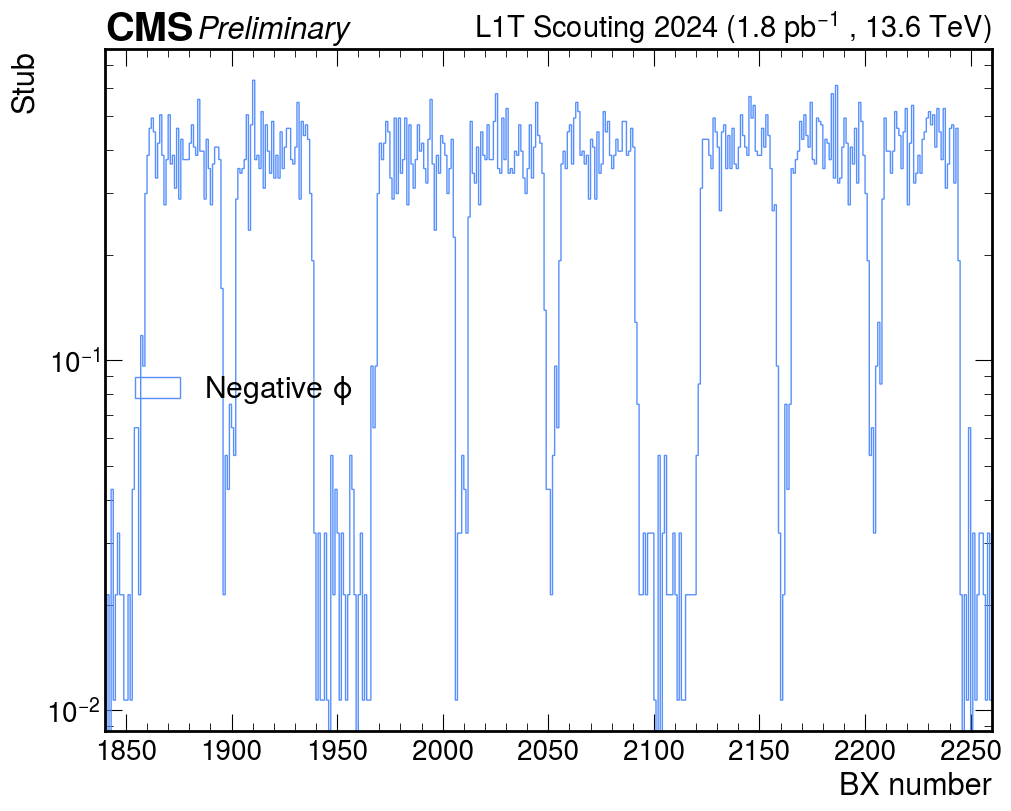

In [41]:
BincountCosmicMuons = np.bincount(PosCosmicMuons.bx) / 4
bx_range = np.arange(ONE_ORBIT_IN_BX + 2)

fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_cms_label(ax, fontsize= FONTSIZE)

#ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BinCountPos), histtype='step', label=r'Positive $\phi$')
ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BincountCosmicMuons), histtype='step', label=r'Negative $\phi$')


ax.set_xlabel('BX number')
ax.set_ylabel('Stub')
ax.set_xlim(0, ONE_ORBIT_IN_BX)
#ax.set_ylim(0.1, 15)
ax.set_xlim(1840, 2260)
ax.legend()

ax.set_yscale('log')